# Compare between different mer

# k = 3, run 10 times, 0.8691

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 3
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.1852
Run 1, Epoch 2: Accuracy = 0.3951
Run 1, Epoch 3: Accuracy = 0.6173
Run 1, Epoch 4: Accuracy = 0.6790
Run 1, Epoch 5: Accuracy = 0.7284
Run 1, Epoch 6: Accuracy = 0.6420
Run 1, Epoch 7: Accuracy = 0.7284
Run 1, Epoch 8: Accuracy = 0.7407
Run 1, Epoch 9: Accuracy = 0.7531
Run 1, Epoch 10: Accuracy = 0.8148
Run 1, Epoch 11: Accuracy = 0.7778
Run 1, Epoch 12: Accuracy = 0.7901
Run 1, Epoch 13: Accuracy = 0.8395
Run 1, Epoch 14: Accuracy = 0.8642
Run 1, Epoch 15: Accuracy = 0.7407
Run 1, Epoch 16: Accuracy = 0.7901
Run 1, Epoch 17: Accuracy = 0.7531
Run 1, Epoch 18: Accuracy = 0.7654
Run 1, Epoch 19: Accuracy = 0.7654
Run 1, Epoch 20: Accuracy = 0.7531
Run 1, Epoch 21: Accuracy = 0.7778
Run 1, Epoch 22: Accuracy = 0.7778
Run 1, Epoch 23: Accuracy = 0.8519
Run 1, Epoch 24: Accuracy = 0.8642
Run 1, Epoch 25: Accuracy = 0.8025
Run 1, Epoch 26: Accuracy = 0.8272
Run 1, Epoch 27: Accuracy = 0.8519
Run 1, Epoch 28: Accuracy = 0.8642
Run 1, Epoch 29: Accuracy = 0

# K = 5, 10 times running(0.942)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 5
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.1605
Run 1, Epoch 2: Accuracy = 0.3704
Run 1, Epoch 3: Accuracy = 0.6667
Run 1, Epoch 4: Accuracy = 0.8025
Run 1, Epoch 5: Accuracy = 0.8148
Run 1, Epoch 6: Accuracy = 0.7901
Run 1, Epoch 7: Accuracy = 0.7901
Run 1, Epoch 8: Accuracy = 0.7778
Run 1, Epoch 9: Accuracy = 0.8395
Run 1, Epoch 10: Accuracy = 0.8148
Run 1, Epoch 11: Accuracy = 0.7778
Run 1, Epoch 12: Accuracy = 0.7531
Run 1, Epoch 13: Accuracy = 0.8642
Run 1, Epoch 14: Accuracy = 0.8272
Run 1, Epoch 15: Accuracy = 0.7901
Run 1, Epoch 16: Accuracy = 0.8642
Run 1, Epoch 17: Accuracy = 0.8519
Run 1, Epoch 18: Accuracy = 0.9012
Run 1, Epoch 19: Accuracy = 0.8025
Run 1, Epoch 20: Accuracy = 0.8765
Run 1, Epoch 21: Accuracy = 0.9259
Run 1, Epoch 22: Accuracy = 0.9630
Run 1, Epoch 23: Accuracy = 0.7778
Run 1, Epoch 24: Accuracy = 0.9136
Run 1, Epoch 25: Accuracy = 0.8148
Run 1, Epoch 26: Accuracy = 0.8765
Run 1, Epoch 27: Accuracy = 0.8519
Run 1, Epoch 28: Accuracy = 0.8272
Run 1, Epoch 29: Accuracy = 0

# K = 6, 10 times running(0.9519)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 10:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.1605
Run 1, Epoch 2: Accuracy = 0.4444
Run 1, Epoch 3: Accuracy = 0.6790
Run 1, Epoch 4: Accuracy = 0.8272
Run 1, Epoch 5: Accuracy = 0.7778
Run 1, Epoch 6: Accuracy = 0.8765
Run 1, Epoch 7: Accuracy = 0.8642
Run 1, Epoch 8: Accuracy = 0.8272
Run 1, Epoch 9: Accuracy = 0.8395
Run 1, Epoch 10: Accuracy = 0.8765
Run 1, Epoch 11: Accuracy = 0.8395
Run 1, Epoch 12: Accuracy = 0.8272
Run 1, Epoch 13: Accuracy = 0.8272
Run 1, Epoch 14: Accuracy = 0.8025
Run 1, Epoch 15: Accuracy = 0.8025
Run 1, Epoch 16: Accuracy = 0.8272
Run 1, Epoch 17: Accuracy = 0.9383
Run 1, Epoch 18: Accuracy = 0.8272
Run 1, Epoch 19: Accuracy = 0.8519
Run 1, Epoch 20: Accuracy = 0.8272
Run 1, Epoch 21: Accuracy = 0.8765
Run 1, Epoch 22: Accuracy = 0.8519
Run 1, Epoch 23: Accuracy = 0.8519
Run 1, Epoch 24: Accuracy = 0.8395
Run 1, Epoch 25: Accuracy = 0.9012
Run 1, Epoch 26: Accuracy = 0.8395
Run 1, Epoch 27: Accuracy = 0.8025
Run 1, Epoch 28: Accuracy = 0.8395
Run 1, Epoch 29: Accuracy = 0

# k=3, filter to 5, run 10 times, 0.668

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 3
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 5:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.0607
Run 1, Epoch 2: Accuracy = 0.1660
Run 1, Epoch 3: Accuracy = 0.2632
Run 1, Epoch 4: Accuracy = 0.3360
Run 1, Epoch 5: Accuracy = 0.4291
Run 1, Epoch 6: Accuracy = 0.4696
Run 1, Epoch 7: Accuracy = 0.5182
Run 1, Epoch 8: Accuracy = 0.5061
Run 1, Epoch 9: Accuracy = 0.5344
Run 1, Epoch 10: Accuracy = 0.5628
Run 1, Epoch 11: Accuracy = 0.5506
Run 1, Epoch 12: Accuracy = 0.4939
Run 1, Epoch 13: Accuracy = 0.5668
Run 1, Epoch 14: Accuracy = 0.5547
Run 1, Epoch 15: Accuracy = 0.5506
Run 1, Epoch 16: Accuracy = 0.5223
Run 1, Epoch 17: Accuracy = 0.4899
Run 1, Epoch 18: Accuracy = 0.5668
Run 1, Epoch 19: Accuracy = 0.5668
Run 1, Epoch 20: Accuracy = 0.5668
Run 1, Epoch 21: Accuracy = 0.5304
Run 1, Epoch 22: Accuracy = 0.5951
Run 1, Epoch 23: Accuracy = 0.6154
Run 1, Epoch 24: Accuracy = 0.6154
Run 1, Epoch 25: Accuracy = 0.5668
Run 1, Epoch 26: Accuracy = 0.5223
Run 1, Epoch 27: Accuracy = 0.5587
Run 1, Epoch 28: Accuracy = 0.5142
Run 1, Epoch 29: Accuracy = 0

# k=5, filter to 5, run 10 times, (0.7547)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 5
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 5:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.0526
Run 1, Epoch 2: Accuracy = 0.1538
Run 1, Epoch 3: Accuracy = 0.2551
Run 1, Epoch 4: Accuracy = 0.3725
Run 1, Epoch 5: Accuracy = 0.4413
Run 1, Epoch 6: Accuracy = 0.5547
Run 1, Epoch 7: Accuracy = 0.5668
Run 1, Epoch 8: Accuracy = 0.5506
Run 1, Epoch 9: Accuracy = 0.5830
Run 1, Epoch 10: Accuracy = 0.6032
Run 1, Epoch 11: Accuracy = 0.6437
Run 1, Epoch 12: Accuracy = 0.6073
Run 1, Epoch 13: Accuracy = 0.6559
Run 1, Epoch 14: Accuracy = 0.6599
Run 1, Epoch 15: Accuracy = 0.6721
Run 1, Epoch 16: Accuracy = 0.5951
Run 1, Epoch 17: Accuracy = 0.6356
Run 1, Epoch 18: Accuracy = 0.5668
Run 1, Epoch 19: Accuracy = 0.6194
Run 1, Epoch 20: Accuracy = 0.6275
Run 1, Epoch 21: Accuracy = 0.6275
Run 1, Epoch 22: Accuracy = 0.5385
Run 1, Epoch 23: Accuracy = 0.5951
Run 1, Epoch 24: Accuracy = 0.6154
Run 1, Epoch 25: Accuracy = 0.6518
Run 1, Epoch 26: Accuracy = 0.6721
Run 1, Epoch 27: Accuracy = 0.6356
Run 1, Epoch 28: Accuracy = 0.6518
Run 1, Epoch 29: Accuracy = 0

# k=6, filter to 5, run 10 times(0.7704)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 5:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []

for run in range(num_runs):
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy

    best_accuracies.append(max_accuracy)

avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'Average Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')


Run 1, Epoch 1: Accuracy = 0.0445
Run 1, Epoch 2: Accuracy = 0.1093
Run 1, Epoch 3: Accuracy = 0.2065
Run 1, Epoch 4: Accuracy = 0.2915
Run 1, Epoch 5: Accuracy = 0.4453
Run 1, Epoch 6: Accuracy = 0.5101
Run 1, Epoch 7: Accuracy = 0.5304
Run 1, Epoch 8: Accuracy = 0.6113
Run 1, Epoch 9: Accuracy = 0.5911
Run 1, Epoch 10: Accuracy = 0.6316
Run 1, Epoch 11: Accuracy = 0.6518
Run 1, Epoch 12: Accuracy = 0.6640
Run 1, Epoch 13: Accuracy = 0.6802
Run 1, Epoch 14: Accuracy = 0.6883
Run 1, Epoch 15: Accuracy = 0.6640
Run 1, Epoch 16: Accuracy = 0.6640
Run 1, Epoch 17: Accuracy = 0.7085
Run 1, Epoch 18: Accuracy = 0.6518
Run 1, Epoch 19: Accuracy = 0.6478
Run 1, Epoch 20: Accuracy = 0.6761
Run 1, Epoch 21: Accuracy = 0.6640
Run 1, Epoch 22: Accuracy = 0.7166
Run 1, Epoch 23: Accuracy = 0.6680
Run 1, Epoch 24: Accuracy = 0.7206
Run 1, Epoch 25: Accuracy = 0.7409
Run 1, Epoch 26: Accuracy = 0.6883
Run 1, Epoch 27: Accuracy = 0.7530
Run 1, Epoch 28: Accuracy = 0.7449
Run 1, Epoch 29: Accuracy = 0

# aa


Let's mathematically evaluate how to choose the optimal k-mer length for DNA sequences of approximately 750 nucleotides.

### Step-by-step Mathematical Reasoning:

Given:

- DNA sequence length \( L \approx 750 \text{ nucleotides} \).

- DNA is composed of 4 nucleotides: \(\{A, T, C, G\}\).

---

## Step 1: Calculate the number of possible k-mers:

- For a k-mer of length \(k\), the number of possible combinations is:
\[
4^k
\]

| k-mer length (k) | Number of combinations (4^k) |
|------------------|------------------------------|
| 3                | \(4^3 = 64\)                   |
| 4                | \(4^4 = 256\)                  |
| 5                | \(4^5 = 1024\)                 |
| 6                | \(4^6 = 4096\)                 |
| 7                | \(4^7 = 16384\)                |

---

## Step 2: Calculate the number of k-mers in a sequence of length 750:

- For a sequence of length \(L\), the number of k-mers generated is approximately:
\[
L - k + 1 \approx L - k
\]

For \(L=750\):

| k-mer length (k) | Number of k-mers per sequence |
|------------------|-------------------------------|
| 4                | \(750 - 4 + 1 = 747\)          |
| 5                | \(750 - 5 + 1 = 746\)          |
| 6                | \(750 - 6 + 1 = 745\)          |
| 7                | \(750 - 7 + 1 = 744\)          |

(Approximately equal numbers.)

---

## Step 3: Calculate Expected Occurrences per k-mer:

- The expected frequency of each unique k-mer, if uniformly random, is approximately:
\[
\text{Frequency per k-mer} = \frac{\text{Total k-mers in sequence}}{4^k}
\]

| k-mer length (k) | Frequency per unique k-mer     |
|------------------|--------------------------------|
| 4                | \(747 / 256 \approx 2.918\)     |
| 5                | \(746 / 1024 \approx 0.729\)    |
| 6                | \(745 / 4096 \approx 0.182\)    |
| 7                | \(744 / 16384 \approx 0.045\)   |

---

## Analysis of Results:

- **k = 4:**  
  - Each unique 4-mer appears ~3 times on average per sequence.
  - Might be too frequent to distinguish meaningful motifs clearly; could generate noise.

- **k = 5**:
  - Each unique 5-mer appears ~0.73 times per sequence (once every ~1.37 sequences).
  - Good balance between capturing recurring motifs without excessive repetition or sparsity.

- **k = 6**:
  - Each unique 6-mer appears ~0.18 times per sequence (approximately once every ~5.5 sequences).
  - Sparse but manageable, good for identifying distinct patterns in larger datasets.

- **k = 7**:
  - Each unique 7-mer appears ~0.045 times per sequence (once every ~22 sequences).
  - Potentially too sparse for effective motif detection unless you have a very large dataset.

---

## Recommended Choice (Mathematically Justified):

- **5-mers (k=5)** provide a balanced frequency (about one occurrence per sequence) to capture clear, distinguishable motifs without excessive sparsity or redundancy.

- **6-mers** could also be good if your analysis focuses on more specific motifs, and your dataset is sufficiently large.

Thus, the mathematically optimal k-mer for DNA sequences of around 750 nucleotides would typically be:

\[
\boxed{k = 5 \text{ or } k = 6}
\]

Would you like to analyze this further with actual data distributions?

# CNN run 10 times, with resamplnig distillation ..., same as in vit, 82.35


########## Student10 (min_count >= 10) ##########
Number of samples after filtering: 1693
Train samples: 1612 Test samples: 81
Number of classes: 81

--- Student10 Run 1/10 ---
Epoch 1/100 | Loss: 9.9799 | Test Acc: 4.94%
Epoch 2/100 | Loss: 3.0105 | Test Acc: 28.40%
Epoch 3/100 | Loss: 1.6497 | Test Acc: 48.15%
Epoch 4/100 | Loss: 0.8692 | Test Acc: 70.37%
Epoch 5/100 | Loss: 0.4665 | Test Acc: 71.60%
Epoch 6/100 | Loss: 0.3240 | Test Acc: 74.07%
Epoch 7/100 | Loss: 0.2361 | Test Acc: 81.48%
Epoch 8/100 | Loss: 0.2306 | Test Acc: 72.84%
Epoch 9/100 | Loss: 0.1808 | Test Acc: 72.84%
Epoch 10/100 | Loss: 0.1506 | Test Acc: 75.31%
Epoch 11/100 | Loss: 0.1487 | Test Acc: 80.25%
Epoch 12/100 | Loss: 0.1072 | Test Acc: 77.78%
Epoch 13/100 | Loss: 0.1522 | Test Acc: 76.54%
Epoch 14/100 | Loss: 0.1159 | Test Acc: 79.01%
Epoch 15/100 | Loss: 0.1227 | Test Acc: 80.25%
Epoch 16/100 | Loss: 0.1159 | Test Acc: 79.01%
Epoch 17/100 | Loss: 0.1113 | Test Acc: 80.25%
Early stopping at epoch 17
Run 1 

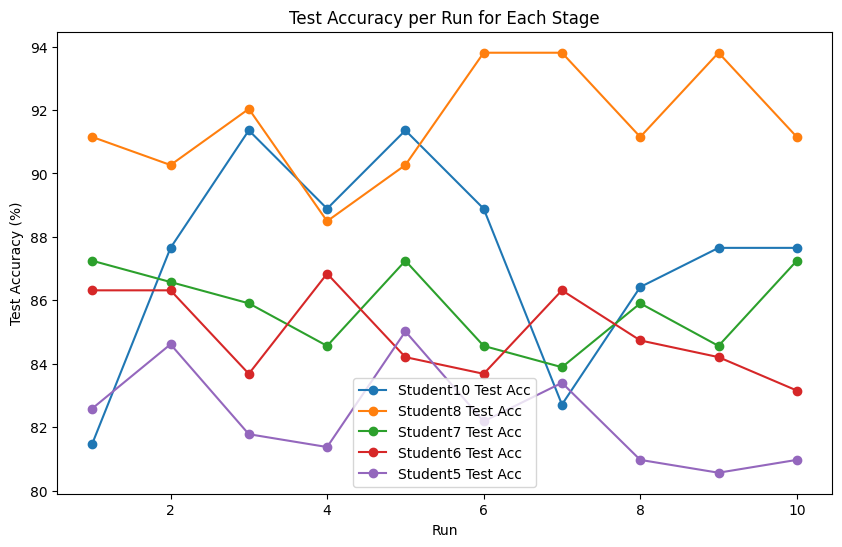

Student10: 87.41%
Student8: 91.59%
Student7: 85.77%
Student6: 84.95%
Student5: 82.35%


In [11]:
import os
import math
import random
from itertools import product
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

###############################
# File paths and constants
###############################
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
# We will not use the originally filtered_vector_file since we need to filter differently per stage.
num_epochs = 100
num_runs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

##########################################
# Helper functions for k-mer vectorization
##########################################
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

##########################################
# Step 1: Clean FASTA headers
##########################################
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            # Write header using the second field if available.
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

##########################################
# Step 2: k-mer vectorization
##########################################
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

##########################################
# Utility: Parse k-mer vector file
##########################################
def parse_kmer_vector_file(filepath):
    # Each line is of the form: ">label<TAB>vec0 vec1 ..."
    raw_data = []
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                continue
            label = parts[0][1:]  # remove '>' prefix
            vector = list(map(int, parts[1].split()))
            raw_data.append((label, vector))
    return raw_data

##########################################
# Utility: Filter classes by minimum count
##########################################
def filter_classes(raw_data, min_count=10):
    label_counts = Counter([label for label, _ in raw_data])
    filtered_data = [(label, vec) for (label, vec) in raw_data if label_counts[label] >= min_count]
    return filtered_data

##########################################
# Utility: Train-test split (per label)
##########################################
def create_train_test_split(raw_data):
    label_to_samples = defaultdict(list)
    for label, vec in raw_data:
        label_to_samples[label].append(vec)
    train_data = []
    test_data = []
    for label, vecs in label_to_samples.items():
        random.shuffle(vecs)
        test_vec = vecs[0]
        train_vecs = vecs[1:]
        test_data.append((label, test_vec))
        for vec in train_vecs:
            train_data.append((label, vec))
    return train_data, test_data

##########################################
# Utility: Resampling to balance classes
##########################################
def resample_dataset(train_data):
    label_to_samples = defaultdict(list)
    for label, vec in train_data:
        label_to_samples[label].append(vec)
    max_count = max(len(samples) for samples in label_to_samples.values())
    resampled_data = []
    for label, samples in label_to_samples.items():
        sampled_vecs = random.choices(samples, k=max_count)
        for vec in sampled_vecs:
            resampled_data.append((label, vec))
    random.shuffle(resampled_data)
    return resampled_data

##########################################
# Dataset class
##########################################
class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data  # list of k-mer count vectors
        self.labels = labels  # list of integer-encoded labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Return vector as float tensor and label as long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

##########################################
# CNN Model (using 1D convolutions)
##########################################
class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim // 8) * 128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x has shape (batch_size, input_dim); add channel dimension.
        return self.model(x.unsqueeze(1))

##########################################
# Distillation & Loss functions
##########################################
def get_overlapping_indices(teacher_label2idx, student_label2idx):
    teacher_indices = []
    student_indices = []
    for label, t_idx in teacher_label2idx.items():
        if label in student_label2idx:
            teacher_indices.append(t_idx)
            student_indices.append(student_label2idx[label])
    return teacher_indices, student_indices

def distillation_loss(student_logits, teacher_logits, student_overlap, teacher_overlap, T, clip_threshold=0.9):
    s_overlap = student_logits[:, student_overlap]  # [B, num_overlap]
    t_overlap = teacher_logits[:, teacher_overlap]  # [B, num_overlap]
    teacher_probs = F.softmax(t_overlap / T, dim=1)
    teacher_probs = torch.clamp(teacher_probs, max=clip_threshold)
    teacher_probs = teacher_probs / teacher_probs.sum(dim=1, keepdim=True)
    kd_loss = F.kl_div(
        F.log_softmax(s_overlap / T, dim=1),
        teacher_probs,
        reduction="batchmean"
    ) * (T * T)
    return kd_loss

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction="mean"):
    ce_loss = F.cross_entropy(inputs, targets, reduction="none")
    pt = torch.exp(-ce_loss)
    loss = alpha * (1 - pt) ** gamma * ce_loss
    if reduction == "mean":
        return loss.mean()
    elif reduction == "sum":
        return loss.sum()
    else:
        return loss

##########################################
# Main multi-stage training pipeline
##########################################
# First, load the raw k-mer vector data.
raw_data_all = parse_kmer_vector_file(kmer_vector_file)

# We will store per-stage test accuracies (per run) for plotting.
stage_test_accs = {
    "Student10": [],
    "Student8": [],
    "Student7": [],
    "Student6": [],
    "Student5": []
}

# To hold teacher models for distillation between stages.
# For stage 1 (Student 10) there is no teacher.
teacher_model = None
teacher_label2idx = None

# Hyperparameters for distillation
temperature = 4.5
alpha = 0.5

# A dictionary to store best average accuracy for each stage.
stage_avg_acc = {}

# Stages and corresponding minimum count thresholds.
stages = [("Student10", 10), ("Student8", 8), ("Student7", 7), ("Student6", 6), ("Student5", 5)]

for stage_name, min_count in stages:
    print(f"\n########## {stage_name} (min_count >= {min_count}) ##########")
    # Filter data based on min_count.
    stage_raw_data = filter_classes(raw_data_all, min_count=min_count)
    print("Number of samples after filtering:", len(stage_raw_data))
    
    # Create train-test split.
    train_data, test_data = create_train_test_split(stage_raw_data)
    print("Train samples:", len(train_data), "Test samples:", len(test_data))
    
    # For Student6 and Student5, apply resampling to training data.
    if stage_name in ["Student6", "Student5"]:
        train_data = resample_dataset(train_data)
        print("After resampling, train samples:", len(train_data))
    
    # Get labels and vectors.
    train_labels = [label for label, vec in train_data]
    train_vectors = [vec for label, vec in train_data]
    test_labels = [label for label, vec in test_data]
    test_vectors = [vec for label, vec in test_data]
    
    # Create a label encoder and mapping.
    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_enc = label_encoder.transform(train_labels)
    test_labels_enc = label_encoder.transform(test_labels)
    # Create a label-to-index dictionary.
    student_label2idx = {label: idx for idx, label in enumerate(sorted(label_encoder.classes_))}
    
    # Create datasets and loaders.
    train_dataset = KmerDataset(train_vectors, train_labels_enc)
    test_dataset = KmerDataset(test_vectors, test_labels_enc)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    input_dim = len(train_vectors[0])
    num_classes = len(label_encoder.classes_)
    print("Number of classes:", num_classes)
    
    # For multi-run experiments.
    run_accs = []
    for run in range(num_runs):
        print(f"\n--- {stage_name} Run {run+1}/{num_runs} ---")
        model = CNNModel(input_dim=input_dim, num_classes=num_classes).to(device)
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
        criterion = nn.CrossEntropyLoss()
        
        best_acc = 0.0
        best_state = None
        patience = 10
        patience_counter = 0
        
        for epoch in range(1, num_epochs+1):
            model.train()
            total_loss = 0.0
            for data, labels in train_loader:
                data, labels = data.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                
                # For Student10, use plain cross-entropy.
                # For others, combine with distillation loss.
                if stage_name == "Student10":
                    loss = criterion(outputs, labels)
                else:
                    # Get teacher logits.
                    with torch.no_grad():
                        teacher_outputs = teacher_model(data)
                    # Compute cross-entropy loss.
                    ce_loss = criterion(outputs, labels)
                    # Get overlapping classes indices.
                    teacher_overlap, student_overlap = get_overlapping_indices(teacher_label2idx, student_label2idx)
                    kd_loss = distillation_loss(outputs, teacher_outputs, student_overlap, teacher_overlap, temperature, clip_threshold=0.9)
                    # For Student7, use focal loss for classification.
                    if stage_name == "Student7":
                        cls_loss = focal_loss(outputs, labels, alpha=0.25, gamma=2.0, reduction="mean")
                    else:
                        cls_loss = ce_loss
                    loss = alpha * kd_loss + (1 - alpha) * cls_loss
                    
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            
            # Evaluation on test set.
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for data, labels in test_loader:
                    data, labels = data.to(device), labels.to(device)
                    outputs = model(data)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
            test_acc = 100.0 * correct / total
            print(f"Epoch {epoch}/{num_epochs} | Loss: {avg_loss:.4f} | Test Acc: {test_acc:.2f}%")
            
            if test_acc > best_acc:
                best_acc = test_acc
                best_state = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Load best state.
        model.load_state_dict(best_state)
        # Freeze model parameters.
        for param in model.parameters():
            param.requires_grad = False
        model.eval()
        print(f"Run {run+1} Best Test Accuracy: {best_acc:.2f}%")
        run_accs.append(best_acc)
    
    avg_stage_acc = sum(run_accs) / len(run_accs)
    stage_avg_acc[stage_name] = avg_stage_acc
    stage_test_accs[stage_name] = run_accs
    print(f"\n*** Average {stage_name} Test Accuracy over {num_runs} runs: {avg_stage_acc:.2f}% ***")
    
    # Set teacher for next stage (if any)
    teacher_model = model
    teacher_label2idx = student_label2idx

##########################################
# Plotting the results
##########################################
plt.figure(figsize=(10, 6))
for stage_name in stages:
    name = stage_name[0]
    plt.plot(range(1, num_runs+1), stage_test_accs[name], marker='o', label=f"{name} Test Acc")
plt.xlabel("Run")
plt.ylabel("Test Accuracy (%)")
plt.title("Test Accuracy per Run for Each Stage")
plt.legend()
plt.show()

# Print average accuracies per stage.
for stage_name, acc in stage_avg_acc.items():
    print(f"{stage_name}: {acc:.2f}%")


# compare accuracy(and delta accuracy) between class, before distillation and after

# before

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict
import time

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
# Also build a global count dictionary for later stage-wise evaluation.
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 5:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []
# For storing stage-wise accuracies across runs (both cumulative and delta)
stage_accuracies = defaultdict(list)
delta_accuracies = defaultdict(list)
# Fixed thresholds: 10, 8, 7, 6, 5.
thresholds = [10, 8, 7, 6, 5]

for run in range(num_runs):
    run_start_time = time.time()  # Start timing for this run

    # --- Prepare train and test data ---
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    # To store predictions and true labels (for stage-wise evaluation) from the best epoch.
    best_preds = []
    best_trues = []

    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start timing for this epoch
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        epoch_duration = time.time() - epoch_start_time

        # Evaluate on test set at the end of each epoch.
        model.eval()
        correct, total = 0, 0
        epoch_preds = []
        epoch_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                epoch_preds.extend(predicted.cpu().numpy())
                epoch_trues.extend(labels.cpu().numpy())
        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f} (Epoch Time: {epoch_duration:.2f} sec)")

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_preds = epoch_preds[:]
            best_trues = epoch_trues[:]

    run_duration = time.time() - run_start_time
    best_accuracies.append(max_accuracy)
    print(f"Run {run+1} best accuracy: {max_accuracy:.4f} (Run Duration: {run_duration:.2f} sec)")

    # --- Stage-wise Accuracy Breakdown ---
    # Convert numeric labels back to genus names for the test set.
    true_genus = label_encoder.inverse_transform(best_trues)
    pred_genus = label_encoder.inverse_transform(best_preds)
    # For each test sample, get the global count (from the entire dataset)
    test_counts = [genera_count[genus] for genus in true_genus]

    for i, t in enumerate(thresholds):
        # Cumulative: samples with count >= threshold t.
        indices_cum = [idx for idx, count in enumerate(test_counts) if count >= t]
        # Delta: samples with count exactly equal to t.
        indices_delta = [idx for idx, count in enumerate(test_counts) if count == t]

        if indices_cum:
            acc_cum = sum(pred_genus[j] == true_genus[j] for j in indices_cum) / len(indices_cum)
            print(f"\nStage (>= {t} samples): Cumulative accuracy = {acc_cum:.4f} over {len(indices_cum)} samples")
            stage_accuracies[f">= {t}"].append(acc_cum)
        else:
            print(f"\nStage (>= {t} samples): No test samples available.")
            stage_accuracies[f">= {t}"].append(0)

        if indices_delta:
            acc_delta = sum(pred_genus[j] == true_genus[j] for j in indices_delta) / len(indices_delta)
            print(f"Stage (== {t} samples): Delta accuracy = {acc_delta:.4f} over {len(indices_delta)} samples")
            delta_accuracies[f"== {t}"].append(acc_delta)
        else:
            print(f"Stage (== {t} samples): No test samples available.")
            delta_accuracies[f"== {t}"].append(0)

        # --- Partition Cumulative Accuracy (for thresholds below the highest) ---
        if i > 0:  # i==0 corresponds to the highest threshold; no partition then.
            prev_t = thresholds[i-1]  # previous (higher) threshold
            # Group 1: samples with global count >= previous threshold.
            indices_prev = [idx for idx, count in enumerate(test_counts) if count >= prev_t]
            # Group 2: new samples with count exactly equal to current threshold.
            indices_new = [idx for idx, count in enumerate(test_counts) if count == t]
            if indices_cum:
                acc_prev = sum(pred_genus[j] == true_genus[j] for j in indices_prev) / len(indices_prev) if indices_prev else 0
                acc_new = sum(pred_genus[j] == true_genus[j] for j in indices_new) / len(indices_new) if indices_new else 0
                print(f"Partition for (>= {t}):")
                print(f"  Accuracy on previous group (>= {prev_t}): {acc_prev:.4f} over {len(indices_prev)} samples")
                print(f"  Accuracy on new delta group (== {t}): {acc_new:.4f} over {len(indices_new)} samples")

# Final overall average accuracy over runs.
avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'\nAverage Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')

# Print average delta accuracy for each threshold.
print("\nAverage Delta Accuracies per Threshold:")
for key, values in delta_accuracies.items():
    avg_delta = sum(values) / len(values)
    print(f"{key}: {avg_delta:.4f}")

# (Optional) Plot stage accuracies across runs.
all_stages = list(stage_accuracies.keys()) + list(delta_accuracies.keys())
avg_stage_acc = [sum(vals)/len(vals) for vals in stage_accuracies.values()] + [sum(vals)/len(vals) for vals in delta_accuracies.values()]

plt.figure()
plt.bar(all_stages, avg_stage_acc)
plt.xlabel('Stage')
plt.ylabel('Average Accuracy')
plt.title('Stage-wise and Delta Average Accuracy over Runs')
plt.xticks(rotation=45)
plt.show()


# after

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import random
import matplotlib.pyplot as plt
from itertools import product
from collections import defaultdict
import time

# Constants
k = 6
input_fasta = 'data1/fungi_ITS_sorted90.fasta'
cleaned_fasta = 'data1/fungi_ITS_cleaned.fasta'
kmer_vector_file = 'data1/fungi_ITS_kmer_vector.txt'
filtered_vector_file = 'data1/fungi_ITS_kmer_vector_filtered.txt'
num_epochs = 100
num_runs = 10

# Helper functions
def generate_kmers(k):
    return [''.join(p) for p in product('ACGT', repeat=k)]

def kmer_vector(seq, k, kmer_index):
    vector = [0] * len(kmer_index)
    for i in range(len(seq) - k + 1):
        kmer = seq[i:i+k]
        if kmer in kmer_index:
            vector[kmer_index[kmer]] += 1
    return vector

class KmerDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert the k-mer vector to float and the label to a long tensor.
        return (torch.tensor(self.data[idx], dtype=torch.float),
                torch.tensor(self.labels[idx], dtype=torch.long))

class CNNModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, 7, padding='same'),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 7, padding='same'),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 7, padding='same'),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear((input_dim//8)*128, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.LeakyReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x is expected to have shape (batch_size, input_dim)
        return self.model(x.unsqueeze(1))

# Step 1: Clean FASTA headers
with open(input_fasta, 'r') as infile, open(cleaned_fasta, 'w') as outfile:
    for line in infile:
        if line.startswith('>'):
            parts = line.strip().split()
            outfile.write(f'>{parts[1]}\n' if len(parts) > 1 else line)
        else:
            outfile.write(line)

# Step 2: k-mer vectorization
kmers = generate_kmers(k)
kmer_index = {kmer: idx for idx, kmer in enumerate(kmers)}

with open(cleaned_fasta, 'r') as infile, open(kmer_vector_file, 'w') as outfile:
    current_sequence, header = '', ''
    for line in infile:
        if line.startswith('>'):
            if current_sequence:
                vector = kmer_vector(current_sequence, k, kmer_index)
                outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")
            header = line.strip()
            current_sequence = ''
        else:
            current_sequence += line.strip()
    if current_sequence:
        vector = kmer_vector(current_sequence, k, kmer_index)
        outfile.write(f"{header}\t{' '.join(map(str, vector))}\n")

# Step 3: Filter sequences by genus frequency
# Build a global count dictionary for stage-wise evaluation.
genera_count = defaultdict(int)
with open(kmer_vector_file, 'r') as f:
    for line in f:
        genus = line.split()[0][1:]
        genera_count[genus] += 1

with open(kmer_vector_file, 'r') as infile, open(filtered_vector_file, 'w') as outfile:
    for line in infile:
        genus = line.split()[0][1:]
        if genera_count[genus] >= 5:
            outfile.write(line)

# Main Experiment Loop
best_accuracies = []
# For storing stage-wise accuracies across runs (both cumulative and delta)
stage_accuracies = defaultdict(list)
delta_accuracies = defaultdict(list)
# Fixed thresholds: 10, 8, 7, 6, 5.
thresholds = [10, 8, 7, 6, 5]

for run in range(num_runs):
    run_start_time = time.time()  # Start timing for the run

    # --- Prepare train and test data ---
    data_by_class = defaultdict(list)
    with open(filtered_vector_file, 'r') as f:
        for line in f:
            label = line.split('\t')[0][1:]
            data_by_class[label].append(line.strip())

    train_data, test_data = [], []
    for samples in data_by_class.values():
        test_sample = random.choice(samples)
        test_data.append(test_sample)
        train_data.extend(s for s in samples if s != test_sample)

    train_vectors = [list(map(int, line.split('\t')[1].split())) for line in train_data]
    train_labels = [line.split('\t')[0][1:] for line in train_data]

    test_vectors = [list(map(int, line.split('\t')[1].split())) for line in test_data]
    test_labels = [line.split('\t')[0][1:] for line in test_data]

    label_encoder = LabelEncoder().fit(train_labels)
    train_labels_encoded = label_encoder.transform(train_labels)
    test_labels_encoded = label_encoder.transform(test_labels)

    train_loader = DataLoader(KmerDataset(train_vectors, train_labels_encoded), batch_size=32, shuffle=True)
    test_loader = DataLoader(KmerDataset(test_vectors, test_labels_encoded), batch_size=32)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = CNNModel(len(train_vectors[0]), len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    max_accuracy = 0
    # To store predictions and true labels (for stage-wise evaluation) from the best epoch.
    best_preds = []
    best_trues = []

    for epoch in range(num_epochs):
        model.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate on test set at the end of each epoch.
        model.eval()
        correct, total = 0, 0
        epoch_preds = []
        epoch_trues = []
        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
                epoch_preds.extend(predicted.cpu().numpy())
                epoch_trues.extend(labels.cpu().numpy())

        accuracy = correct / total
        print(f"Run {run+1}, Epoch {epoch+1}: Accuracy = {accuracy:.4f}")

        if accuracy > max_accuracy:
            max_accuracy = accuracy
            best_preds = epoch_preds[:]
            best_trues = epoch_trues[:]

    best_accuracies.append(max_accuracy)
    run_duration = time.time() - run_start_time
    print(f"Run {run+1} best accuracy: {max_accuracy:.4f} (Run Duration: {run_duration:.2f} sec)")

    # --- Stage-wise Accuracy Breakdown ---
    # Convert numeric labels back to genus names for the test set.
    true_genus = label_encoder.inverse_transform(best_trues)
    pred_genus = label_encoder.inverse_transform(best_preds)
    # For each test sample, get the global count from the entire dataset.
    test_counts = [genera_count[genus] for genus in true_genus]

    for i, t in enumerate(thresholds):
        # Cumulative: samples with count >= threshold t.
        indices_cum = [idx for idx, count in enumerate(test_counts) if count >= t]
        # Delta: samples with count exactly equal to t.
        indices_delta = [idx for idx, count in enumerate(test_counts) if count == t]

        if indices_cum:
            acc_cum = sum(pred_genus[i] == true_genus[i] for i in indices_cum) / len(indices_cum)
            print(f"\nStage (>= {t} samples): Cumulative accuracy = {acc_cum:.4f} over {len(indices_cum)} samples")
            stage_accuracies[f">= {t}"].append(acc_cum)
        else:
            print(f"\nStage (>= {t} samples): No test samples available.")
            stage_accuracies[f">= {t}"].append(0)

        if indices_delta:
            acc_delta = sum(pred_genus[i] == true_genus[i] for i in indices_delta) / len(indices_delta)
            print(f"Stage (== {t} samples): Delta accuracy = {acc_delta:.4f} over {len(indices_delta)} samples")
            delta_accuracies[f"== {t}"].append(acc_delta)
        else:
            print(f"Stage (== {t} samples): No test samples available.")
            delta_accuracies[f"== {t}"].append(0)

        # Partition the cumulative accuracy for thresholds below the highest.
        if i > 0:
            prev_t = thresholds[i-1]
            # Group 1: samples with global count >= previous (higher) threshold.
            indices_prev = [idx for idx, count in enumerate(test_counts) if count >= prev_t]
            # Group 2: new samples with count exactly equal to the current threshold.
            indices_new = [idx for idx, count in enumerate(test_counts) if count == t]
            if indices_cum:
                acc_prev = sum(pred_genus[i] == true_genus[i] for i in indices_prev) / len(indices_prev) if indices_prev else 0
                acc_new = sum(pred_genus[i] == true_genus[i] for i in indices_new) / len(indices_new) if indices_new else 0
                print(f"Partition for (>= {t}):")
                print(f"  Accuracy on previous group (>= {prev_t}): {acc_prev:.4f} over {len(indices_prev)} samples")
                print(f"  Accuracy on new delta group (== {t}): {acc_new:.4f} over {len(indices_new)} samples")

# Final overall average accuracy over runs.
avg_accuracy = sum(best_accuracies) / len(best_accuracies)
print(f'\nAverage Highest Accuracy over {num_runs} runs: {avg_accuracy:.4f}')

# Print average delta accuracy for each threshold.
print("\nAverage Delta Accuracies per Threshold:")
for key, values in delta_accuracies.items():
    avg_delta = sum(values) / len(values)
    print(f"{key}: {avg_delta:.4f}")

# (Optional) Plot stage accuracies across runs.
all_stages = list(stage_accuracies.keys()) + list(delta_accuracies.keys())
avg_stage_acc = [sum(vals)/len(vals) for vals in stage_accuracies.values()] + [sum(vals)/len(vals) for vals in delta_accuracies.values()]

plt.figure()
plt.bar(all_stages, avg_stage_acc)
plt.xlabel('Stage')
plt.ylabel('Average Accuracy')
plt.title('Stage-wise and Delta Average Accuracy over Runs')
plt.xticks(rotation=45)
plt.show()
